In [1]:
import matplotlib.pyplot as plt
from astroquery.skyview import SkyView
from astropy.coordinates import SkyCoord
from astropy import coordinates as coords
from astroquery.sdss import SDSS
from astropy.wcs import WCS
import astropy.units as u
from astropy.io import fits

import numpy as np

import petrofit

from datetime import datetime

ImportError: cannot import name 'update_default_config' from 'astropy.config.configuration' (/home/adam/anaconda3/envs/prospector/lib/python3.10/site-packages/astropy/config/configuration.py)

In [2]:
pos = coords.SkyCoord(ra=189.183288812633, dec=14.6450833, unit="deg", frame='icrs')
xid = SDSS.query_region(pos, radius='5 arcsec', spectro=True)

hdu = SDSS.get_images(matches=xid,band='g')[0][0]

xid

<Table length=1>
       ra              dec       ...      specobjid      run2d
    float64          float64     ...        int64        int64
---------------- --------------- ... ------------------- -----
189.183288812633 14.645083328157 ... 1991792035627034624    26

In [28]:
#hdu.header

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


(121.0040480319019, 521.0040480319019)

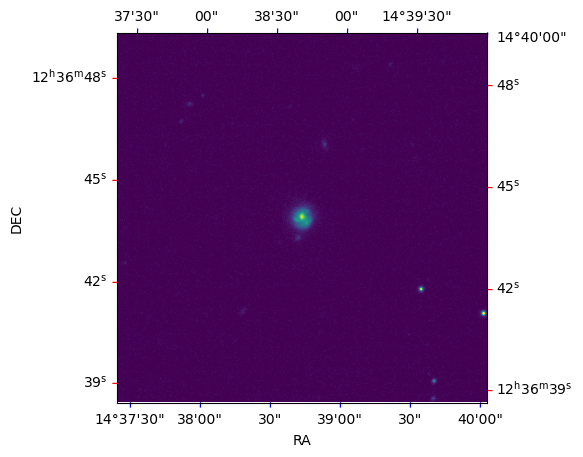

In [4]:
wcs = WCS(hdu.header, relax=True)
ax=plt.subplot(projection=wcs)
ax.imshow(hdu.data ,vmin=0,vmax=1)
#ax.colorbar()
#plt.scatter(1025,745,marker='.')
lon, lat = ax.coords
lon.set_ticks(color='red')
lon.set_ticks_position('lbtr')
lon.set_ticklabel_position('lbtr')
lat.set_ticks(color='blue')
lat.set_ticks_position('lbtr')
lat.set_ticklabel_position('lbtr')
plt.xlabel('RA')
plt.ylabel('DEC')

x,y=wcs.world_to_pixel(pos)
plt.xlim(x-200,x+200)
plt.ylim(y-200,y+200)
#plt.scatter(x,y)

In [5]:
from photutils.background import Background2D, MedianBackground

data = hdu.data

bkg_estimator = MedianBackground()

bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   bkg_estimator=bkg_estimator)



a=200
b=200

data = data - bkg.background  # subtract the background
data=data[int(y-b):int(y+b),int(x-a):int(x+a)]

In [6]:
threshold = 1.5 * bkg.background_rms
threshold = threshold[int(y-b):int(y+b),int(x-a):int(x+a)]

In [7]:
from astropy.convolution import convolve

from photutils.segmentation import make_2dgaussian_kernel

kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0

convolved_data = convolve(data, kernel)

In [8]:
from photutils.segmentation import detect_sources

segment_map = detect_sources(convolved_data, threshold, npixels=10)

print(segment_map)


<photutils.segmentation.core.SegmentationImage>
shape: (400, 400)
nlabels: 14
labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


Text(0.5, 1.0, 'Segmentation Image')

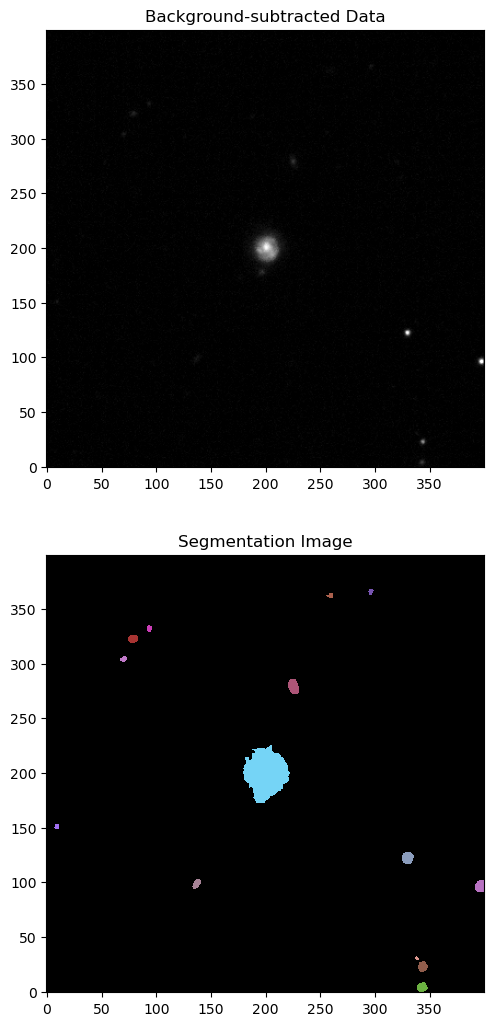

In [9]:
from astropy.visualization import SqrtStretch

from astropy.visualization.mpl_normalize import ImageNormalize

norm = ImageNormalize(stretch=SqrtStretch())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))

ax1.imshow(data, vmin=0, vmax=1,origin='lower', cmap='Greys_r')

ax1.set_title('Background-subtracted Data')

ax2.imshow(segment_map, origin='lower', cmap=segment_map.cmap,

           interpolation='nearest')

ax2.set_title('Segmentation Image')

In [10]:
from photutils.segmentation import deblend_sources

segm_deblend = deblend_sources(convolved_data, segment_map,

                               npixels=10, nlevels=32, contrast=0.001,

                               progress_bar=False)

In [11]:
from photutils.segmentation import SourceFinder

finder = SourceFinder(npixels=10, progress_bar=False)

segment_map = finder(convolved_data, threshold)

segment_map

<photutils.segmentation.core.SegmentationImage>
shape: (400, 400)
nlabels: 15
labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

In [12]:
from photutils.segmentation import SourceCatalog

cat = SourceCatalog(data, segm_deblend, convolved_data=convolved_data)

cat

<photutils.segmentation.catalog.SourceCatalog>
Length: 15
labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

In [13]:
tbl = cat.to_table()

tbl['xcentroid'].info.format = '.2f'  # optional format

tbl['ycentroid'].info.format = '.2f'

tbl['kron_flux'].info.format = '.2f'

tbl

<QTable length=15>
label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
int64  float64   float64  ...     float64      float64    float64   
----- --------- --------- ... --------------- --------- ------------
    1    343.09      3.80 ...             nan      5.50          nan
    2    343.70     22.62 ...             nan      7.36          nan
    3    338.44     30.20 ...             nan      1.08          nan
    4    396.72     95.97 ...             nan     18.01          nan
    5    137.14     98.24 ...             nan      3.07          nan
    6    329.75    122.15 ...             nan     15.76          nan
  ...       ...       ... ...             ...       ...          ...
   10     79.24    322.18 ...             nan      4.13          nan
   11     93.81    331.43 ...             nan      1.48          nan
   12    259.07    361.54 ...             nan      2.27          nan
   13    296.45    365.19 ...             nan      1.45          nan
   14    196.17    177.88 ...             nan     13.90          nan
   15    201.24    199.50 ...             nan    237.30          nan

In [14]:
#Only works for full image as x,y changes when image dim changed
# Starx, Stary = x,y
# for i in tbl:
#     x1=i[1]
#     y1=i[2]
#     if Starx > (x1-5) and Starx < (x1+5):
#         print()
#     if Stary > (y1-5) and Stary < (y1+5):
#         print(i[0])

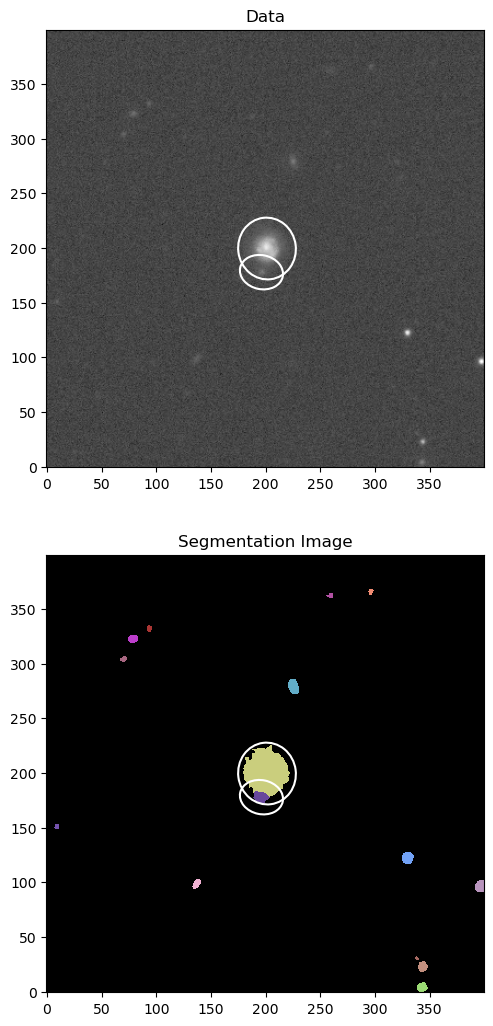

In [15]:
from astropy.visualization import simple_norm

norm = simple_norm(data, 'sqrt')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))

ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)

ax1.set_title('Data')

ax2.imshow(segm_deblend, origin='lower', cmap=segm_deblend.cmap,interpolation='nearest')

ax2.set_title('Segmentation Image')

cat[13:15].plot_kron_apertures(ax=ax1, color='white', lw=1.5)

cat[13:15].plot_kron_apertures(ax=ax2, color='white', lw=1.5)



In [16]:
#kron flux to magnitude using m=−2.5log10​(F)+ZP
#Kron flux no good? Misses half of light? 
zp=22.5
f=237.30 #+3.5

In [17]:
def m(f):
    return -2.5*np.log10(f)+zp

In [18]:
ABmag=m(f)
print(ABmag)

16.561755654456654


In [19]:
def nmaggie(m):
    return 10**(-0.4*m)*1E9

In [20]:
nmaggie(ABmag)

237.2999999999993

# Radial Profile

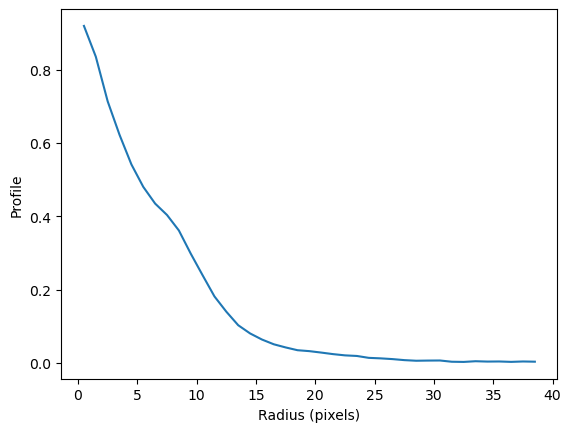

In [27]:
from photutils.profiles import RadialProfile

#img = plt.imread()
center = (201.24, 199.50)
edge_radii = np.arange(40)
rp = RadialProfile(data, center, edge_radii)

rp.plot(label='Radial Profile')